In [5]:
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()
%matplotlib inline


In [6]:
#%unload_ext vimception


In [7]:
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import pandas as pd
import numpy as np
import netCDF4
from matplotlib.ticker import MultipleLocator
from scipy.interpolate import *

In [10]:
filename='/Users/ptg21/data/projects/blowsea/ancil_creation/ch2br2_jrates_N48_regrid.nc'
ncfile1    = netCDF4.Dataset(filename)
lon1        = ncfile1.variables['longitude'][:]
lat1        = ncfile1.variables['latitude'][:] 
times1      = ncfile1.variables['tim']
jrates      = ncfile1.variables['CH2Br2_j_rate'][:,:,:,:]
nmonths, nlevels, ny1, nx1 = np.shape(jrates)
new_jrates = np.empty_like(jrates)
new_jrates_int = np.empty_like(jrates)
for ivar in range (0, ny1):
        new_jrates_int [:,:,ivar,:] = jrates[:,:, (ny1-1)-ivar,:]
        
for ivar in range (0,nlevels):
    new_jrates [:,ivar,:,:] = new_jrates_int[:,nlevels-ivar-1,:,:]

#nboundaries = nlevels + 1
#nx1 = len(lon1)
#ny1 = len(lat1)

In [14]:
filename='/Users/ptg21/data/projects/blowsea/ancil_creation//ch2br2_jrates_pressure_field_regrid_N48.nc'
ncfile2     = netCDF4.Dataset(filename)
lon2        = ncfile2.variables['longitude'][:]
lat2        = ncfile2.variables['latitude'][:] 
times2      = ncfile2.variables['tim']
pressure    = ncfile2.variables['Pressure'][:]

nx2 = len(lon2)
ny2 = len(lat2)
pressure_int = np.empty_like(pressure)

for ivar in range (0,ny2):
    pressure_int [:,:,ivar,:] = pressure[:,:,ny2-ivar-1,:]

pressure = np.empty_like(pressure)    

for ivar in range (0,nlevels):
    pressure [:,ivar,:,:] = pressure_int[:,nlevels-ivar-1,:,:]


In [17]:
# get file containing heights, pressures for L85 ancil
filename='/Users/ptg21/data/projects/Blowsea/ancil_creation/xjcira.p.nc'
ncfile3     = netCDF4.Dataset(filename)

lon3        = ncfile3.variables['longitude'][:]
lat3        = ncfile3.variables['latitude'][:]
press       = ncfile3.variables['p'][:]
hybrid_ht   = ncfile3.variables['hybrid_ht'][:]
times3      = ncfile3.variables['t']
nmonths3, nheights3, ny3, nx3 = np.shape(press)


In [18]:
err_str=''
OHres=np.zeros_like(press)
OHres_ht=np.zeros_like(press)

nmonths,nlevels,ny1,nx1=np.shape(new_jrates)


for imonth in range (0, nmonths):
    print imonth
    for ilat in range(0, ny1):
        for ilon in range (0, nx1):
            pold = pressure[imonth,:,ilat,ilon]
            pnew = press   [imonth,:,ilat,ilon]
            # vals to be interpolated
            vals = new_jrates[imonth, :, ilat, ilon]
            # array for interpolated data
            res = np.zeros_like(hybrid_ht)
                # for each new level, find corresponding pressure levels and interpolate OH concentration
                # need to check the case that there are two levels between the old levels.  think i did this!
            for newlev in range(0, len(pnew)):
                    
                    found = False
                    for oldlev in range(0, len(pold)-1):
                    #print pnew[newlev], pold[newlev]
                        if pnew[newlev] < pold[oldlev] and pnew[newlev] >= pold[oldlev+1]:
                            # calculate gradient over this interval, pold[lev] to pold[lev+1]
                            grad = (vals[oldlev]-vals[oldlev+1])/(pold[oldlev]- pold[oldlev+1])
                            # calculate a value at thew intermediate pressure
                            val_at_newlev=vals[oldlev]+grad*(pnew[newlev]-pold[oldlev])            
                            #print str(pnew[newlev])+ 'Pa  lies between '+ str(pold[oldlev])+' and ' +str(pold[oldlev+1])+ ' Pa and corresponds to a height of ' + str(hybrid_ht[newlev]) +' m'#+ ' extrapolated value', val_at_newlev
                            #print 'JRATE at this point', val_at_newlev,' between', vals[oldlev], 'at ', pold[oldlev], 'and ', pold[oldlev+1], vals[oldlev], '\n'
                            res[newlev] = val_at_newlev
                            found = True
                    if found == False:
                        #print "not found", pnew[newlev], pold.min()
                        if pnew[newlev]< pold.min():
                            # the pressure of the new level is too low, ie at the top of the atm where photolysis is high
                            #print "low", newlev
                            res[newlev] = vals.max()
                            found = True
                        elif pnew[newlev] > pold.max():
                            # the pressure of the new level is too high, ie at the bottom of the atm where photolysis is low
                            #print "high", newlev, pnew[ivar], pold.max()
                            res[newlev]  = vals.min()
                            found = True
            # add the results to the output array
            OHres_ht[imonth, :, ilat, ilon] = res

0
1
2
3
4
5
6
7
8
9
10
11


In [19]:
np.save('interp_ch2br2_rates.npy',OHres_ht)

In [20]:
interp_ch2br2_rates=np.load('interp_ch2br2_rates.npy')

In [21]:
%%bash
rm -Rf N96_L85_ch2br2_jrates.nc

In [22]:
from netCDF4 import Dataset
import time
# Create HDF5 *format*, classic *model*
dataset = Dataset('N96_L85_ch2br2_jrates.nc', 'w', format='NETCDF4')

# Global Attributes
dataset.description = 'TEST NETCDF-CF COMPLIANT SCRIPT'
dataset.history = 'Created ' + time.ctime(time.time())
dataset.source = ''
dataset.Conventions = 'CF-1.0'
dataset.standard_name_vocabulary='CF-1.0'

height = dataset.createDimension('hybrid_ht', nheights3)
height     = dataset.createVariable('hybrid_ht',    np.int32,   ('hybrid_ht',))

time  = dataset.createDimension('time',      None)
time  = dataset.createVariable('time',       'f8', ('time',)) # or can use np as below

lat   = dataset.createDimension('latitude',  ny3)
lat   = dataset.createVariable('latitude',   np.float32, ('latitude',))

lon   = dataset.createDimension('longitude', nx3)
lon   = dataset.createVariable('longitude',  np.float32, ('longitude',))

jrates         = dataset.createVariable('jrate', np.float32, ('time','hybrid_ht','latitude', 'longitude',))

lon[:]   = lon3[:]
lat[:]   = lat3[:]
height[:] = hybrid_ht[:]
time[:]  = times3[:]

jrates[:,:,:,:] = interp_ch2br2_rates[:,:,:,:]

# Variable Attributes
lat.standard_name = 'latitude'
lat.units = 'degrees_north'
lat.cartesian_axis = "Y"
lat.axis = 'Y'
lat.actual_range = -90.0, 90.0

lon.standard_name = 'longitude'
lon.units = 'degrees_east'
lon.cartesian_axis = "X"
lon.axis = "X"
lat.actual_range = 0.0, 360.0

jrates.units = 's-1'
jrates.standard_name='Ch2Br2 photolysis rate'

height.units = 'm'
height.axis='Z'
height.positive='up'
height.standard_name = 'hybrid_pressure_levels'


time.standard_name = 'time'
time.long_name = 'time'
time.units = 'days since 1999-12-01 00:00:00'
time.calendar = '360_day'
time.axis = 'T'
print ('success')
dataset.close()

success


In [ ]:
# check plot for comp with ncview create the figure and axes instances.
fig = plt.figure(num=2,figsize=(10,15),dpi=300)
zvar=0
m1 = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=0,urcrnrlon=360.,resolution='c')
lons1, lats1 = m1.makegrid(nx2, ny2)
x1,y1 = m1(lons1, lats1)
im1 = m1.contourf(x1, y1, new_jrates[0,0,:,:])
m1.colorbar(im1,location='bottom',pad="5%")
m1.drawcoastlines(linewidth=0.25)


In [ ]:
plt.subplot(1,2,1)
plt.contourf(jrates[0,0,:,:])
plt.colorbar()
plt.subplot(1,2,2)
plt.contourf(new_jrates[0,-1,:,:])
plt.colorbar()
#plt.plot(OHres_ht[0,:,1,15])

In [ ]:
plt.contourf(new_jrates[11,0,:,:])
plt.colorbar()

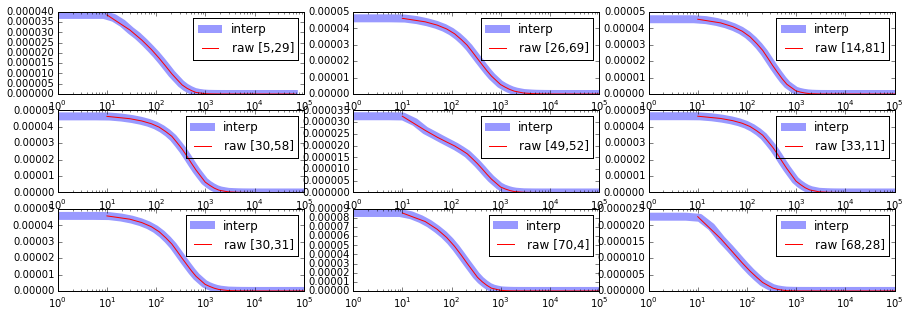

In [23]:
from random import randint

plt.figure(figsize=(15,5))

for ivar in range (1,10):
    plt.subplot(3,3,ivar)
    month=randint(0,11)
    lat=randint(0,ny1-1)
    lon=randint(0,nx1-1)
    plt.semilogx(press[month,:,lat,lon],interp_ch2br2_rates[month,:,lat,lon], lw=8, alpha=0.4, label='interp')
    plt.semilogx(pressure[month,:,lat,lon],new_jrates[month,:,lat,lon],'r-', label='raw [' + str(lat)+","+str(lon)+"]")
    plt.xlim([1,1e5])
    plt.legend()